In [1]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd

import scipy as sp
from scipy.interpolate import LSQUnivariateSpline

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift

# Lecture 8: Beyond Linearity

Linear models are relatively simple to describe and implement, and have advantages over other approaches in terms of interpretation and inference. However, standard linear regression can have significant limitations in terms of predictive power. This is because the linearity assumption is almost always an approximation, and sometimes a poor one.

We saw in the previous lectures improvements to the linear model by reducing the complexity of the model and hence it's variance but this will only get us up to a point.

We now relax the linearity assumption while still attempting to maintain as much interpretability as possible by looking at:

* Polynomial regression: extra predictors, obtained by raising each of the original predictors to a power
* Step functions: cut the range of a variable into $K$ distinct regions in order to produce a qualitative variable
* Regression splines: an extension of the above two methods
* Smoothing splines: use a smoothing penalty
* Local regression: similar to splines but use overlapping regions
* Generalized additive models: extend all these models to deal with many predictors

## Polynomial Regression

Let's use the `Wage` data and factorise the categorical data via dummy variables:

In [2]:
wage_df = pd.read_csv("../data/Wage.csv",index_col ='id')
wage_df.head()

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
id,,,,,,,,,,,,
231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


Generally speaking, it is unusual to use a power greater than 3 or 4 for a feature and fit a model for it. For higher powers the polynomial curve can become overly flexible and can take on some very strange shapes, especially at the boundaries.

Let us think about fitting a degree-4 polynomial of `wage` as a function of `age`. Even though this is a linear regression model like any other, the individual coefficients are not of particular interest. Instead, we look at the entire fitted function.

## Orthogonal Polynomial Regression

We could of course construct new age features with increasing powers, but we have to keep in mind an issue that can pop-up in practice. Powers of say `age` could be correlated with one another and regression on correlated  predictors leads to unstable coefficients: the coefficients from an order-3 polynomial regression might change drastically when moving to an order-4 regression. Also if values in our feature column take large values then their powers will grow even larger leading to a poorly conditioned matrix when it comes to solving gradient descent. Larger values will also mean smaller coefficients leading to under-flow problems or coefficients which are hard to interpret.

We can fix this by using *orthogonal polynomial basis*. This is just a change in the coordinate system so has no effect on the regression.

The following helper `poly()` does just this:

In [3]:
# from http://davmre.github.io/python/2013/12/15/orthogonal_poly/
def poly(x, degree = 1):
    n = degree + 1
    x = np.asarray(x).flatten()
    if(degree >= len(np.unique(x))):
        print("'degree' must be less than number of unique points")
        return
    xbar = np.mean(x)
    x = x - xbar
    X = np.fliplr(np.vander(x, n))
    q, r = np.linalg.qr(X)

    z = np.diag(np.diag(r))
    raw = np.dot(q, z)
    
    norm2 = np.sum(raw ** 2, axis=0)
    alpha = (np.sum((raw ** 2) * np.reshape(x,(-1,1)), axis=0) / norm2 + xbar)[:degree]
    Z = raw / np.sqrt(norm2)
    return Z, norm2, alpha

X = poly(wage_df["age"].values, 4)[0]
X[0:5, 1:]

array([[-0.0386248 ,  0.05590873, -0.07174058,  0.08672985],
       [-0.0291326 ,  0.02629807, -0.01454995, -0.00259928],
       [ 0.00409008, -0.01450655, -0.00013318,  0.01448009],
       [ 0.00092602, -0.0148314 ,  0.00451367,  0.01265751],
       [ 0.01200024, -0.00981585, -0.01113663,  0.01021146]])

Intercepts: -6287691075.27
Coefficients: [  3.44391030e+11   4.47067854e+02  -4.78315807e+02   1.25521688e+02
  -7.79111830e+01]


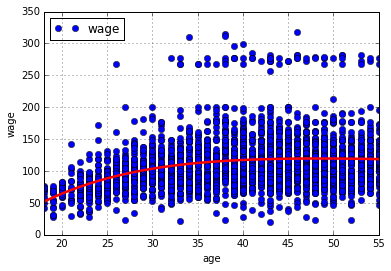

In [4]:
y = wage_df["wage"].values
reg = LinearRegression()
reg.fit(X, y)
print "Intercepts:", reg.intercept_
print "Coefficients:", reg.coef_
ax = wage_df.plot(x="age", y="wage", style="o")
ax.set_ylabel("wage")
# The poly() method cannot return features for a single X value, 
# so we have to plot the raw predictions.
age = wage_df["age"].values
ypred = reg.predict(X)
polyline = np.poly1d(np.polyfit(age, ypred, 4))
xs = range(int(np.min(age)), int(np.max(age)))
ys = polyline(xs) 
ax.plot(xs, ys, 'r', linewidth=2.5)

## Polynomial Logistic Regression

It seems like the wages are from two distinct populations: there appears to be a high earners group earning more than $250K per year as well as a low earners group. We can treat `wage` as a binary variable by splitting it into these two groups. Logistic regression can then be used to predict this binary response, using polynomial functions of `age` as predictors.

Intercepts: [ -5.19706030e-05]
Coefficients: [[ -3.41216496e-06   4.21910018e-04  -1.38561865e-02  -1.00530633e-03
   -5.19706030e-05]]
MSE: 0.0263333333333


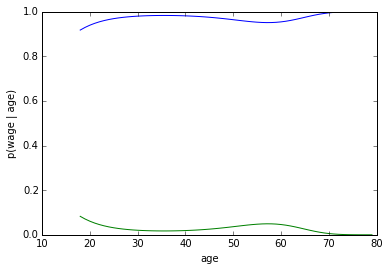

In [5]:
X = np.vander(wage_df["age"],5)
y = wage_df["wage"].map(lambda w: 1 if w > 250 else 0).values
reg = LogisticRegression()
reg.fit(X, y)
print "Intercepts:", reg.intercept_
print "Coefficients:", reg.coef_

ypred = reg.predict(X)
print "MSE:", mean_squared_error(y, ypred)

xs = range(min(wage_df["age"]), max(wage_df["age"]))
plt.plot(xs, reg.predict_proba(np.vander(xs,5)))
plt.xlabel("age")
plt.ylabel("p(wage | age)")

## Splines

Now we discuss a flexible class of basis functions that extends upon the polynomial regression approach above.

Instead of fitting a high-degree polynomial over the entire range of X, piecewise polynomial regression involves fitting separate low-degree polynomials over different regions of $X$.

E.g. a piecewise cubic polynomial works by fitting:

$$
y_i = \beta_0 + \beta_1 x_1 + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + \epsilon_i,
$$

where the coefficients $\beta_0$, $\beta_1$, $\beta_2$, and $\beta_3$ differ in different parts of the range of $X$. The points where the coefficients change are called knots.

So a model with one knot at $c$ will need to fit two models one for $x_i < c$ and one for $x_i \ge c$. Using more knots leads to a more flexible piecewise polynomial. The problem is that the model will be discontinuous and looks ridiculous! Below we see various  piecewise polynomials fit to the data with a knot at `age=50`. The cubic polynomials are unconstrained.

![](../data/piecewise-fit.png)

### Constraints

To fix this problem we can fit under a constraint: the fitted curve must be continuous. We do this by asking that the  first and second derivatives of the piecewise polynomials are continuous at the knots. These models are known as splines but unfortunately, splines can have high variance at the outer range of the predictors that is, when $X$ takes on either a very small or very large value.


### Choosing the Location of Knots

The regression spline is most flexible in regions that contain a lot of knots, because in those regions the polynomial coefficients can change rapidly. Hence, one option is to place more knots in places where we feel the function might vary most rapidly, and to place fewer knots where it seems more stable. 

While this option can work well, in practice it is common to place knots in a uniform fashion. Another way is to knot location at the 25th, 50th, and 75th percentiles of $X$. 

Another option is to use Mean shift clustering to discover “blobs” in a smooth density of samples.  It is a centroid-based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region. These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids.

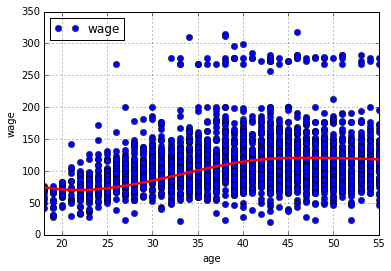

In [6]:
ages = wage_df["age"].values
wages = wage_df["wage"].values
X = np.vstack((ages, wages)).T

# cluster points to find the knot location
msc = MeanShift()
msc.fit(X)
knots = msc.cluster_centers_[:, 0]

# fit a spline over the points
spl = LSQUnivariateSpline(ages, wages, knots)
xs = range(np.min(ages), np.max(ages))
ys = spl(xs)

# plot the points and the spline
ax = wage_df.plot(x="age", y="wage", style="o")
ax.set_ylabel("wage")
ax.plot(xs, ys, 'r', linewidth=2.5)

### Choosing the Number of Knots

By now this should seem familiar:  use cross-validation. With this method, we remove a portion of the data, fit a spline with a certain number of knots to the remaining data, and then use the spline to make predictions for the held-out portion. We repeat this process multiple times until each observation has been left out once, and then compute the overall cross-validated RSS. This procedure can be repeated for different numbers of knots and we choose the number with the lowest RSS.

## Smoothing Splines

We now introduce a somewhat different approach that also produces a spline. Recall in fitting a smooth curve to a set of data, what we really want to do is find some function, $g(x)$ with small RSS = $\sum_{i=1}^{n} (y_i - g(x_i))^2$. But if we do not put a constraint on $g(x)$ then we can always make RSS = 0 by choosing a very flexible function that interpolates all of the $y_i$. Our model will overfit. What we really want is a function that makes RSS small but is also smooth.

A natural approach is to find the function $g$ that minimises:

$$
\sum_{i=1}^{n} (y_i - g(x_i))^2 + \lambda \int g''(t)^2\,\mathrm{d}t,
$$

where $\lambda$ is non-negative tuning parameter. The function that minimises this is called a smoothing spline. The second derivative is a measure of roughness and we are forcing the function to be smooth with this penalty. When $\lambda$ is huge we will get a straight line and when it is small the function will be very jumpy.

### Choosing $\lambda$

It turns out that we can compute the LOOCV error very efficiently for smoothing splines and thus we choose the $\lambda$ with the lowest LOOCV RSS error.

## Local Regression

Local regression is a different approach for fitting flexible non-linear functions, which involves computing the fit at a target point $x_0$ using only the nearby training observations. Below we see a target point near 0.4 and another near 0.05. The   blue line represents the function from which the data was generated and the orage is the local regression estimate. 

![](../data/local-regression.png)

Formally local regression at $X=x_0$ involves:

1. Gather the fraction $s=k/n$ of training points whose $x_i$ are closest to $x_0$
2. Assign a weight $K_{i0}=K(x_i,x_0)$ to each point in this neighbourhood such that points further away from $x_0$ have zero weight and the closer ones have a heigher weight. All but the nearest $k$ get weight zero.
3. Fit a weighted least square regression of the $y_i$ on the $x_i$ using the above weights by finding the coefficients that minimise:
$$
\sum_{i-1}^{n}K_{i0}(y_i - \beta_0 -\beta_1 x_i)^2.
$$
4. The model at $x_0$ is given by $\hat{f}(x_0)=\hat{\beta}_0 + \hat{\beta}_1 x_0$.

This method however suffers from the curse of dimensionality and usually performs poorly for $p$ larger than 3 or 4.